In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm
from random import seed, randint, choice

from swarm_sim import *

%matplotlib inline 

In [2]:
# 1st dataset: N=50
PATH = '..\\..\\data\\swarm-50-sats-scenario\\coords_v1_if_LLO-'
EXPORT_PATH = 'output\\data'
ROW_DATA = 7
NB_NODES = 50
DURATION = 8641 # Number of data rows, not time!
REVOLUTION = 1800 # Number of data rows
CONNECTION_RANGE = 30 # km


In [3]:
satellites = {} # Dict(sat_id: DataFrame)
with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df_data = pd.read_csv(PATH+str(i)+'.csv', skiprows= lambda x: x<ROW_DATA, header=0)
        satellites[i] = df_data
        pbar.update(1)
        
swarm_data = {} # Dict{timestamp: Swarm}
with tqdm(total=REVOLUTION, desc='Converting to topologies') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(CONNECTION_RANGE,
                    nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                    )
        pbar.update(1)

neighbor_matrices = {} # Dict{timestamp: matrix}
with tqdm(total=REVOLUTION, desc='Computing neighbor matrices') as pbar:
    for t in range(REVOLUTION):
        neighbor_matrices[t] = swarm_data[t].neighbor_matrix()
        pbar.update(1)

topo_graphs = {} # Dict{timestamp: Graph}
with tqdm(total=REVOLUTION, desc='Converting to NetworkX graphs') as pbar:
    for t in range(REVOLUTION):
        topo_graphs[t] = swarm_data[t].swarm_to_nxgraph()
        pbar.update(1)

Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]

Converting to NetworkX graphs: 100%|██████████| 1800/1800 [00:05<00:00, 320.66it/s]


## Temporal evolution
Analysed metrics:
- Network size (NS)
- Average degree (AD): number of direct neighbor(s) for each node, averaged
- Graph density (GD): ratio of observed edges over maximum possible number of edges
- Average clustering coefficient (ACC): ratio of observed edges in the neighborhood over maximum possible number of edges, averaged
- Diameter (Dia): maximum shortest path length between all pairs of nodes

Implemented algorithms for comparison:
- Random Node Division (RND)
- Multiple Independent Random Walks (MIRW)
- Forest Fire Division (FFD)

In [4]:
def jain(avg, std):
    cv = std/avg
    return 1.0/(1 + pow(cv,2))

In [5]:
# Reference temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
ref_ad, ref_gd, ref_acc = [], [], []

for t,swarm in swarm_data.items():
    ref_ad.append(np.mean(swarm.degree()))
    ref_gd.append(swarm.graph_density())
    ref_acc.append(np.mean(swarm.cluster_coef()))
    
# Run only once
diameters = []
with tqdm(total=len(swarm_data.keys()), desc='Diameter') as pbar:
    for swarm in swarm_data.values():
        diameters.append(swarm.diameter(swarm)[2]-1)
        pbar.update(1)
ref_ml = np.mean(diameters)

Diameter: 100%|██████████| 1800/1800 [02:16<00:00, 13.18it/s]


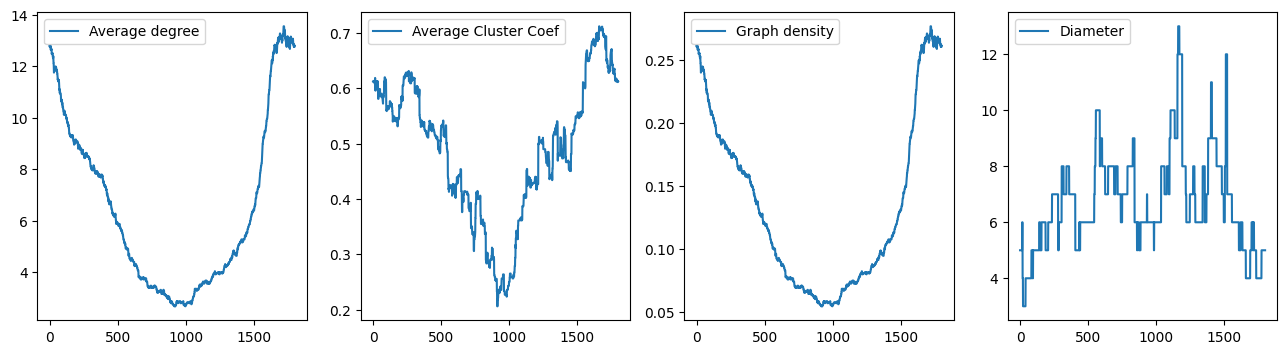

In [6]:
fig, axes = plt.subplots(ncols=4, figsize=(16,4))
idx = swarm_data.keys()

ax = axes[0]
ax.plot(idx, ref_ad, label='Average degree')
ax.legend()

ax = axes[1]
ax.plot(idx, ref_acc, label='Average Cluster Coef')
ax.legend()

ax = axes[2]
ax.plot(idx, ref_gd, label='Graph density')
ax.legend()

ax = axes[3]
ax.plot(idx, diameters, label='Diameter')
ax.legend()

In [7]:
avg_ref_ad = np.mean(ref_ad)
avg_ref_acc = np.mean(ref_acc)
avg_ref_gd = np.mean(ref_gd)

x = 2
print('Reference values (whole swarm)')
print('\tAverage degree:', round(avg_ref_ad, x))
print('\tAverage clustering coefficient:', round(avg_ref_acc, x))
print('\tGraph Density:', round(avg_ref_gd, x))

Reference values (whole swarm)
	Average degree: 6.53
	Average clustering coefficient: 0.49
	Graph Density: 0.13


In [8]:
NB_GROUPS = 10
NB_REPETITIONS = 1

## 1. Random Node Division

In [9]:
graph = topo_graphs[0]
print(graph)

Graph with 50 nodes and 320 edges


In [10]:
swarm = swarm_data[0]
swarm.reset_groups()

groups = swarm.RND(n=10, s=1, by_id=True) # <==================== ALGO CHOICE 

group_assignment = {}
for node in swarm.nodes:
    group_assignment[node.id] = node.group

for gid, nid_list in groups.items():
    print('Group', gid)
    print(nid_list)

Group 0
[2, 19, 31, 43]
Group 1
[14, 28, 32, 42, 46, 49]
Group 2
[1, 18, 20, 21, 22]
Group 3
[3, 4, 8, 15, 26, 39]
Group 4
[13, 23, 45]
Group 5
[7, 16, 36, 47]
Group 6
[0, 24, 25, 38, 41, 44]
Group 7
[9, 11, 12, 27, 40]
Group 8
[17, 29, 30, 34, 35, 48]
Group 9
[5, 6, 10, 33, 37]


In [19]:
# use this to compute group degree (replace nbunch by group nodes)
np.mean(nx.degree(graph, nbunch=[0,1]))

nx.average_clustering(graph, nodes=[0,1])
nx.diameter(graph)

NetworkXError: Found infinite path length because the graph is not connected

In [10]:
with tqdm(total=REVOLUTION, desc='RND computation') as pbar:
    distrib_degree = {}
    distrib_cc = {}
    #distrib_gd = {}
    distrib_dia = {}

    for t in range(REVOLUTION):
        swarm = swarm_data[t]
        graph = topo_graphs[t]

        avg_degree = []
        avg_cc = []
        #group_density = []
        dia = []

        for group_id, node_list in groups.items():
            avg_degree.append(np.mean(nx.degree(graph, nbunch=node_list)))
            avg_cc.append(nx.average_clustering(graph, nodes=node_list))
            #group_density.append()
            dia.append()

            

In [11]:
# Group temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
group_ad, group_gd, group_acc = [], [], []

for t,swarms in swarm_rnd.items():
    group_ad.append(np.nanmean([np.nanmean(sw.degree()) for sw in swarms]))
    group_gd.append(np.mean([sw.graph_density() for sw in swarms]))
    group_acc.append(np.nanmean([np.nanmean(sw.cluster_coef()) for sw in swarms]))  

avg_group_ad = np.nanmean(group_ad)
avg_group_acc = np.nanmean(group_acc)    
avg_group_gd = np.nanmean(group_gd)

std_ad = np.sqrt(np.nanmean((group_ad - avg_ref_ad)**2))
std_acc = np.sqrt(np.nanmean((group_acc - avg_ref_acc)**2))
std_gd = np.sqrt(np.nanmean((group_gd - avg_ref_gd)**2))

C:\Users\ankoc\AppData\Local\Temp\ipykernel_1732\268300152.py:5: RuntimeWarning: Mean of empty slice
  group_ad.append(np.nanmean([np.nanmean(sw.degree()) for sw in swarms]))
C:\Users\ankoc\AppData\Local\Temp\ipykernel_1732\268300152.py:7: RuntimeWarning: Mean of empty slice
  group_acc.append(np.nanmean([np.nanmean(sw.cluster_coef()) for sw in swarms]))


In [12]:
avg_group_ad = np.mean(group_ad)
avg_group_acc = np.mean(group_acc)    
avg_group_gd = np.mean(group_gd)

std_ad = np.sqrt(np.mean((group_ad - avg_ref_ad)**2))
std_acc = np.sqrt(np.mean((group_acc - avg_ref_acc)**2))
std_gd = np.sqrt(np.mean((group_gd - avg_ref_gd)**2))

print('\nGroup values')
print('\tAverage degree:', round(avg_group_ad, x))
print('\tAverage clustering coefficient:', round(avg_group_acc, x))
print('\tGraph Density:', round(avg_group_gd, x))

print('\nStandard deviations')
print('\tAD:', round(std_ad, x))
print('\tACC:', round(std_acc, x))
print('\tGD:', round(std_gd, x))

print('\nVariation coefficients')
print('\tAD:', round(std_ad/avg_group_ad, x+2))
print('\tACC:', round(std_acc/avg_group_acc, x+2))
print('\tGD:', round(std_gd/avg_group_gd, x+2))

Reference values (whole swarm)
	Average degree: 6.53
	Average clustering coefficient: 0.49
	Graph Density: 0.13

Group values
	Average degree: 10.02
	Average clustering coefficient: 0.52
	Graph Density: 0.96

Standard deviations
	AD: 4.65
	ACC: 0.05
	GD: 0.83

Variation coefficients
	AD: 0.4644
	ACC: 0.1065
	GD: 0.8638


In [14]:
group_diameters = []

with tqdm(total=NB_GROUPS, desc='Group diameter') as pbar:
    for group_id in range(NB_GROUPS):
        for t,swarm in swarm_data.items():
            group_diameters.append(swarm.diameter(swarm_rnd[t][group_id])[2]-1)
        pbar.update(1)
            

Group diameter: 100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


In [22]:
avg_dia = np.mean(group_diameters)
std_dia = np.std(group_diameters)

print('Group diameter')
print('Mean:', round(avg_dia, x))
print('Deviation:', round(std_dia, x))
print('Jains index:', round(jain(avg_dia, std_dia), x+2))

Group diameter
Mean: 3.24
Deviation: 2.08
Jains index: 0.7077


In [23]:
network_sizes = []

for t, group_data in group_distrib.items(): # comm_data = Dict(comm_id:list(count)), groups = Dict(timestamp:comm_data)
    network_sizes.extend([e for distribs in group_data.values() for e in distribs])
    pbar.update()

avg_ns = np.mean(network_sizes)
std_ns = np.std(network_sizes)

print('Group size')
print('Mean:', round(avg_ns, x))
print('Deviation:', round(std_ns, x))
print('Jains index:', round(jain(avg_ns, std_ns), x+2))

Group size
Mean: 5.0
Deviation: 2.12
Jains index: 0.8472
